In [92]:
import pandas as pd
import seaborn as sns

! pip3 install pyspark
import sys
from pyspark.sql import SparkSession
import argparse
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType



[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [93]:
customers_df = pd.read_csv('./data/customers.csv')
articles_df = pd.read_csv('./data/articles.csv')
transactions_df = pd.read_csv('./data/transactions_train.csv')

### Explore

In [94]:
print(customers_df.isnull().sum())
# print(articles_df.isnull().sum())
print(transactions_df.isnull().sum())


customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64
t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64


In [95]:
# print(customers_df.duplicated().sum())
# print(articles_df.duplicated().sum())
# print(transactions_df.duplicated().sum())
transactions_df[transactions_df.duplicated()].head()

,t_dat,customer_id,article_id,price,sales_channel_id
15,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,501820043,0.016932,2
18,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,671505001,0.033881,2
20,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,631848002,0.033881,2
21,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,631848002,0.033881,2
22,2018-09-20,000aa7f0dc06cd7174389e76c9e132a67860c5f65f9706...,631848002,0.033881,2


In [96]:
transactions_df.count()
# transactions_df = transactions_df.drop_duplicates()


t_dat               31788324
customer_id         31788324
article_id          31788324
price               31788324
sales_channel_id    31788324
dtype: int64

In [97]:
transactions_df = transactions_df.drop_duplicates()

In [98]:
transactions_df.count()

t_dat               28813419
customer_id         28813419
article_id          28813419
price               28813419
sales_channel_id    28813419
dtype: int64

In [99]:
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2


### Deduplication

#### Articles

##### Several data points are represented as both nominal and discrete values, 
* Retain only nominal data for processing such as product_type_name, graphical_appearance_name
* Drop discrete data value such as product_type_no, graphical_appearance_no

In [100]:
redundant_columns = [
    'product_code',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]

articles_df.drop(columns = redundant_columns, axis=1, inplace = True)

##### Article categories can be represetned solely using either index_name or index_group_name
* index_name provides further subcategories
* drop index_group_names

[Text(0.5, 1.0, 'index_group_name vs index_name')]

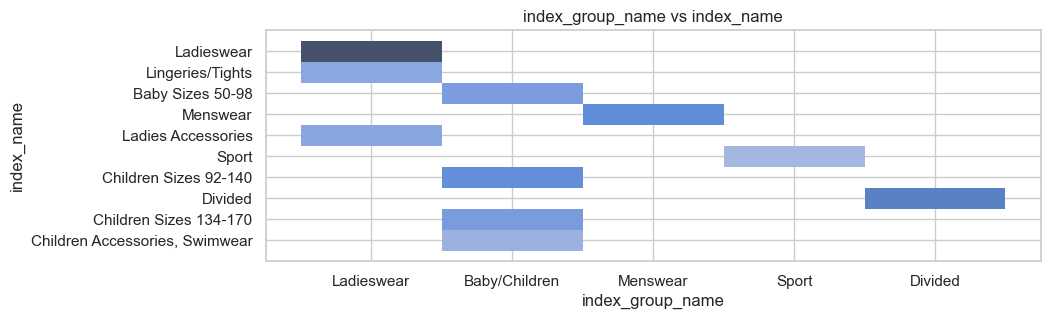

In [89]:
sns.set_style('whitegrid')
sns.histplot(articles_df, x="index_group_name", y="index_name").set(title='index_group_name vs index_name')

In [85]:
articles_df.drop("index_group_name", axis=1, inplace = True)

In [91]:
articles_df.head()

,article_id,prod_name,product_type_name,product_group_name,graphical_appearance_name,colour_group_name,perceived_colour_value_name,perceived_colour_master_name,department_name,index_name,index_group_name,section_name,garment_group_name,detail_desc
0,108775015,Strap top,Vest top,Garment Upper body,Solid,Black,Dark,Black,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,Strap top,Vest top,Garment Upper body,Solid,White,Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,Strap top (1),Vest top,Garment Upper body,Stripe,Off White,Dusty Light,White,Jersey Basic,Ladieswear,Ladieswear,Womens Everyday Basics,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,OP T-shirt (Idro),Bra,Underwear,Solid,Black,Dark,Black,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,OP T-shirt (Idro),Bra,Underwear,Solid,White,Light,White,Clean Lingerie,Lingeries/Tights,Ladieswear,Womens Lingerie,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


### Spark Join

In [22]:
# TESTING PURPOSES ONLY
# Perform joins on samples and verify output
spark = SparkSession.builder.getOrCreate()

sample_cust_spark_df = spark.read.format("csv").option("header", "true").load("./spark_test_data/cust_sample.csv")
sample_art_spark_df = spark.read.format("csv").option("header", "true").load("./spark_test_data/articles_sample.csv")
sample_txn_spark_df = spark.read.format("csv").option("header", "true").load("./spark_test_data/txn_sample.csv")

joined_customer_transactions_df = sample_txn_spark_df.join(sample_cust_spark_df, on="customer_id")
joined_sample_df = joined_customer_transactions_df.join(sample_art_spark_df, on=['article_id'], how='inner')

joined_sample_df.write.csv("./spark_test_data/output", mode='overwrite', header=True)


23/04/24 21:53:55 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [23]:
# Perform joins on full df
spark = SparkSession.builder.getOrCreate()

spark_customer_df = spark.read.format("csv").option("header", "true").load("./data/customers.csv")
spark_articles_df = spark.read.format("csv").option("header", "true").load("./data/articles.csv")
spark_transactions_df = spark.read.format("csv").option("header", "true").load("./data/transactions_train.csv")

joined_cust_trans_df = spark_transactions_df.join(spark_customer_df, on="customer_id")
joined_df = joined_cust_trans_df.join(spark_articles_df, on=['article_id'], how='inner')

In [24]:
joined_df.coalesce(1).write.csv("./data/joined_dataframe", mode='overwrite', header=True)

In [26]:
print(joined_df.head(1))

[Row(article_id='0147339034', customer_id='e8769150304d10862f5d4de22e461a4c6e435bd4dcc58fa146949d5e52638c88', t_dat='2018-12-14', price='0.03049152542372881', sales_channel_id='2', FN='1.0', Active='1.0', club_member_status='ACTIVE', fashion_news_frequency='Regularly', age='66', postal_code='9b24635b57ae2535445a00d7534066aa385a17317616d15d61da8527341dddf5', product_code='0147339', prod_name='6P SS BODY', product_type_no='256', product_type_name='Bodysuit', product_group_name='Garment Upper body', graphical_appearance_no='1010001', graphical_appearance_name='All over pattern', colour_group_code='10', colour_group_name='White', perceived_colour_value_id='3', perceived_colour_value_name='Light', perceived_colour_master_id='9', perceived_colour_master_name='White', department_no='6515', department_name='Baby basics', index_code='G', index_name='Baby Sizes 50-98', index_group_no='4', index_group_name='Baby/Children', section_no='44', section_name='Baby Essentials & Complements', garment_gro

In [27]:
print(joined_df.columns)

['article_id', 'customer_id', 't_dat', 'price', 'sales_channel_id', 'FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age', 'postal_code', 'product_code', 'prod_name', 'product_type_no', 'product_type_name', 'product_group_name', 'graphical_appearance_no', 'graphical_appearance_name', 'colour_group_code', 'colour_group_name', 'perceived_colour_value_id', 'perceived_colour_value_name', 'perceived_colour_master_id', 'perceived_colour_master_name', 'department_no', 'department_name', 'index_code', 'index_name', 'index_group_no', 'index_group_name', 'section_no', 'section_name', 'garment_group_no', 'garment_group_name', 'detail_desc']
